## Section Two: Deep Learning - Semantic Segmentation on Sentinel-2 Imagery
In this section, you will implement a pipeline that performs semantic segmentation on Sentinel-2
imagery using a pretrained model. At this stage, we want to perform basic segmentation on 3 or
so classes: Water, Vegetation and Buildings.

#### Objective:
Given:
- An AOI (given as GeoJSON).
- A target date (You may select any date within the last 5 years)

Your task is to:
- Download the Sentinel-2 data for the target date for that AOI. If data is unavailable for
the target date, retrieve data for the closest available date.
- Select a pretrained model suited to this task. Important: Explain why you picked this
model. Don’t hesitate to go into detail here, on the training dataset used, the
performance metrics, tradeoffs etc. We intentionally did not preselect a model, as we
want to assess and understand your model selection process. This is a key skill we will
be looking at.
- Process the data to the right format for the model
- Output predictions for our AOI and target date using the selected model. We do not
expect a specific output type, just the one outputted by the model (csv, GeoTIFF, png).
You are expected to submit the output along with your code.

#### Notes:
- You may use either PyTorch or Tensorflow.
- If the AOI generates too large of a GeoTIFF for reasonable inference times, you are
allowed to reduce the area accordingly.
- In this section, **you are not expected to fine-tune the model**, but use it as is.

In [2]:
import json
import datetime
import numpy as np
import os

target_date = datetime.date(2023, 8, 30)
with open("../AOI_Rubicon.geojson") as f:
    aoi = json.load(f)


In [13]:
from datetime import timedelta

def find_nearest_available_date(catalog, data_collection, geometry, target_date, max_days=30):
    # Start by searching in the past (starting from the target date)
    time_window = 0
    while time_window <= max_days:
        for delta in [time_window, -time_window]:  # Check both future (positive) and past (negative)
            search_date = target_date + timedelta(days=delta)
            search_time = (search_date.strftime("%Y-%m-%d"), search_date.strftime("%Y-%m-%d"))
            
            # Perform the search query to check if there are images for the date
            search_iterator = catalog.search(
                data_collection,
                geometry=geometry,
                time=search_time,
                filter='eo:cloud_cover < 20',
                fields={"include": ["properties.datetime"], "exclude": []}
            )
            
            # If the search finds results, return the date
            results = list(search_iterator)
            if results:
                return results[0]["properties"]["datetime"][:10]  # Return the date in yyyy-mm-dd format
        time_window += 1  # Increase the window and try again

    # If no results are found after searching ±max_days in both directions, raise an exception
    raise Exception(f"No valid acquisitions found within ±{max_days} days of {target_date.strftime('%Y-%m-%d')}")


https://bigearth.net/#about

In [ ]:
from sentinelhub import (
    SentinelHubRequest, SentinelHubCatalog, SHConfig,
    CRS, Geometry, DataCollection, MimeType
)


with open('../AOI_Rubicon.geojson', 'r') as file:
    geojson_data = json.load(file)["features"][0]["geometry"]

print(geojson_data)

geometry = Geometry.from_geojson(geojson_data, crs=CRS.WGS84)

# Set up config
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

# Catalog to find acquisition dates
catalog = SentinelHubCatalog(config=config)

search_iterator = catalog.search(
                DataCollection.SENTINEL2_L2A,
                geometry=geometry,
                time=target_date,
                filter='eo:cloud_cover < 20',
                fields={"include": ["properties.datetime"], "exclude": []}
            )
if list(search_iterator):
    date = target_date
else:
    date = find_nearest_available_date(
        catalog=catalog,
        data_collection=DataCollection.SENTINEL2_L2A,
        geometry=geometry,
        target_date=target_date,
        max_days=30  # Search ±30 days from target date
    )



print(f"Using nearest available date: {date}")

evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02", "B03", "B04"]
        }],
        output: {
            bands: 3
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

evalscript_nvdi = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [(sample.B08 - sample.B04) / (sample.B08 + sample.B04)];
}
"""

evalscript_evi="""
//VERSION=3
function setup() {
    return {
        input: ["B02", "B04", "B08"],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
        }
    };
}

function evaluatePixel(samples) {
    return [2.5 * (samples.B08 - samples.B04) / ((samples.B08 + 6.0 * samples.B04 - 7.5 * samples.B02) + 1.0)]
"""

ndvi_stack = []
transform = None
crs = None

# Get bounding box in lat/lon (WGS84)
bounds = geometry.bbox
print(f"Bounding Box (lat/lon): {bounds}")

earth_radius = 6371000

# Function to convert lat/lon difference to meters (simplified formula)
def lat_lon_to_meters(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Compute the differences in radians
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    # Haversine formula to compute the distance (great-circle distance)
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Earth radius in meters
    distance = earth_radius * c
    return distance

lat_diff = lat_lon_to_meters(bounds.min_y, bounds.min_x, bounds.max_y, bounds.max_x)  # distance in meters (North-South)
lon_diff = lat_lon_to_meters(bounds.min_y, bounds.min_x, bounds.min_y, bounds.max_x)  # distance in meters (East-West)

print(f"Latitude difference in meters: {lat_diff}")
print(f"Longitude difference in meters: {lon_diff}")

# Sentinel-2 resolution (example: 10m for RGB bands)
resolution = 10  # Spatial resolution in meters (for Sentinel-2's RGB bands)

# Calculate width and height in pixels
width = int(lon_diff / resolution)  # Convert East-West distance to pixels
height = int(lat_diff / resolution)  # Convert North-South distance to pixels

scale_factor = 0.1  # Scale down the image by 10%

while width > 2500 or height > 2500:
    width = int(width * scale_factor)
    height = int(height * scale_factor)



request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=(date, date)
    )],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    size=(width, height),
    geometry=geometry,
    config=config
)

img = request.get_data()[0]
print(img.shape)

print(img.max(), img.min())
rgb_image = (img).astype(np.uint8)

# Convert to a PIL image
rgb_image_pil = Image.fromarray(rgb_image)
# Save the image as a PNG
rgb_image_pil.save(f'rgb_{date}.png')
print(f"Saved RGB image for {date} to rgb_{date}.png")

{'coordinates': [[[5.429163466084987, 46.13806674872461], [5.429163466084987, 45.50223271109695], [7.127353602241698, 45.50223271109695], [7.127353602241698, 46.13806674872461], [5.429163466084987, 46.13806674872461]]], 'type': 'Polygon'}
Using nearest available date: 2023-09-01
Bounding Box (lat/lon): 5.429163466084987,45.50223271109695,7.127353602241698,46.13806674872461
Latitude difference in meters: 149383.3519315627
Longitude difference in meters: 132345.0726616761


/tmp/ipykernel_53583/2790481376.py:102: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(f"Bounding Box (lat/lon): {bounds}")


(1493, 1323, 3)
255 0
Saved RGB image for 2023-09-01 to rgb_2023-09-01.png


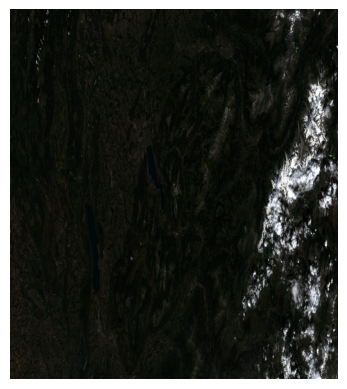

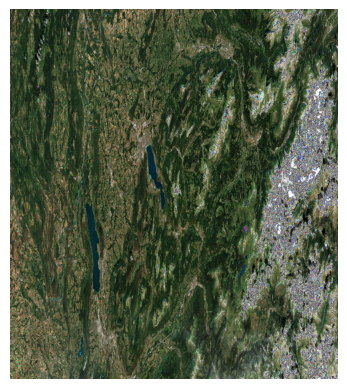

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

img = cv2.imread('rgb_2023-09-01.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

brightened_img = np.clip(img * 5, 0, 255)
plt.imshow(brightened_img)
plt.axis('off')
plt.show()


(1400, 1400, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step
(43, 43, 3)
[[1431 1431 1431 ... 1701 1701 1597]
 [1431 1431 1431 ... 1701 1701 1131]
 [1781 1793 1677 ... 1701 1701 1701]
 ...
 [1463 1463 1463 ... 1256 1256 1256]
 [1463 1463 1463 ... 1906 1256 1557]
 [1828 1463 1463 ... 1906 1906 1557]]


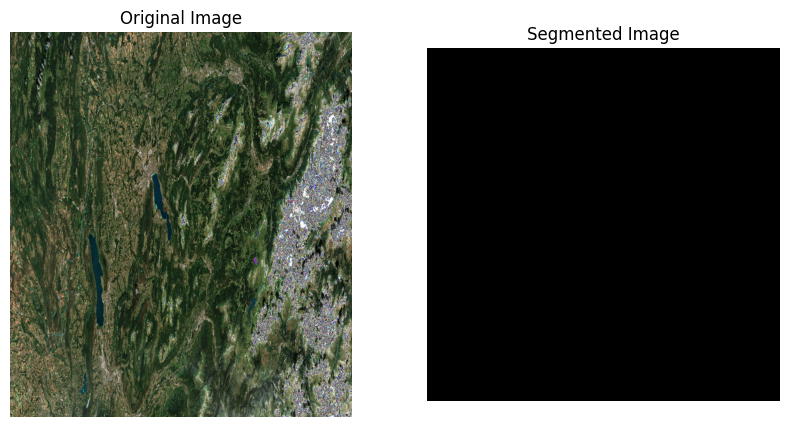

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
input_size = (1400, 1400)

model = tf.keras.models.DeepLabV3ImageSegmenter.from_preset(
    "deeplab_v3_plus_resnet50_pascalvoc")
# Define your class labels (this assumes you have 3 classes: water, earth, and building)
class_labels = ['water', 'earth', 'building']

# Load and preprocess your image (resize it to the required input size for the model)
img = cv2.imread('rgb_2023-09-01.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
brightened_img = np.clip(img * 5, 0, 255)

# Resize image to fit model input size (e.g., 256x256 or whatever is required)

image_resized = cv2.resize(brightened_img, input_size)
print(image_resized.shape)

# Normalize the image to the range expected by the model (0-1)
image_normalized = np.expand_dims(image_resized, axis=0) / 255.0

# Make the prediction
predictions = model.predict(image_normalized)

# The predictions will give the probability for each pixel belonging to each class
# You can apply a threshold to classify the pixels into your desired classes

# Post-process the predictions (optional)
segmentation_map = np.argmax(predictions, axis=-1)[0]  # Convert the predictions to class labels

# Map the class labels to colors (RGB) for visualization
# You need to define a color map for your classes (water, earth, building)
class_colors = {
    'water': [0, 0, 255],      # Blue
    'earth': [0, 255, 0],      # Green
    'building': [255, 0, 0]    # Red
}

# Create an RGB image of the segmentation map
segmented_image = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)
print(segmented_image.shape)
print(segmentation_map)

# Map each class label to its corresponding RGB color
for i, class_name in enumerate(class_labels):
    segmented_image[segmentation_map == i] = class_colors[class_name]

# Show the original and segmented images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(brightened_img)
plt.title("Original Image")
plt.axis("off")

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis("off")

plt.show()

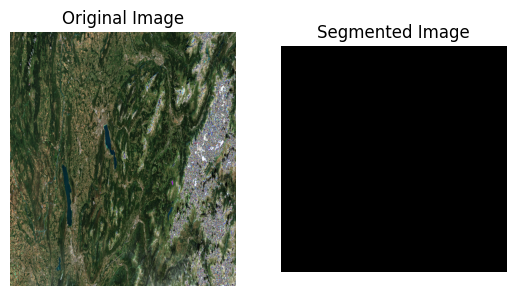